In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os
from IPython.display import display

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.data_transform import log_moulus_nfold
from cell_inference.utils.feature_extractors.SummaryStats2D import GRID_SHAPE
from cell_inference.utils.data_manager import NpzFilesCollector

isCNN = True
isRF = True
isTrain = False
epochs = 100
TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats7'
STATS_SET = 'FullStats5'

if not 'get_ipython' in globals():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true', help="Train model")
    parser.add_argument('--test', action='store_false', dest='train', help="Test model only")
    parser.set_defaults(train=True)
    parser.add_argument('--cnn', action='store_true', help="Train with CNN")
    parser.add_argument('--fcn', action='store_false', dest='cnn', help="Train with FCN")
    parser.add_argument('--rf', action='store_true', dest='rf', help="Train with Random Forest")
    parser.set_defaults(cnn=True)
    parser.set_defaults(rf=False)
    parser.add_argument('-e', type=int, nargs='?', default=epochs, help="Epochs of train", metavar='Epochs')
    parser.add_argument('-trial', type=str, nargs='?', default=TRIAL_NAME, help="Trial name", metavar='Trial')
    parser.add_argument('-stats', type=str, nargs='?', default=None, help="Summary statistics set name", metavar='Stats')
    args = parser.parse_args()
    isTrain = args.train
    isRF = args.rf
    isCNN = args.cnn
    epochs = args.e
    TRIAL_NAME = args.trial
    STATS_SET = args.stats
else:
    %matplotlib inline

isCNN = isCNN and not isRF

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

if isCNN:
    try:
        LFP = np.load(LFP_PATH)
    except:
        LFP = NpzFilesCollector(LFP_PATH)
    with LFP:
        lfp = LFP['x'] * 1000 # convert to uV
        labels = LFP['y'][LFP['good_indices']]
        ys = LFP['ys']
else:
    try:
        STATS = np.load(STATS_PATH)
    except:
        STATS = NpzFilesCollector(STATS_PATH)
    with STATS:
        summ_stats = STATS['x']
        labels = STATS['y']
        ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


### Select summary statistics

In [3]:
if not isCNN:
    if STATS_SET is None:
            stats_set_name = ''
            summ_stats_id = slice(None)
    else:
        stats_set_name = STATS_SET
        summ_stats_id = np.loadtxt(os.path.join(TRIAL_PATH, stats_set_name + '_id.txt'), dtype=int)

    summ_stats = summ_stats[:, summ_stats_id]

### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
1291,-140.188672,190.244164,-0.127758,118.208367,0.192090,0.617497,0.448101
2927,-103.345836,164.510325,-0.274125,174.880618,0.189934,0.412179,0.440335
2867,-100.894196,131.219924,-0.008710,195.816535,0.274598,0.400337,0.429205
3942,-95.379071,199.553830,0.173896,415.560304,0.325907,1.309025,0.548089
670,-94.977105,186.228019,-0.271295,141.032966,0.287009,1.283384,0.797019
...,...,...,...,...,...,...,...
629,255.347216,195.167725,0.137741,1185.035885,0.258433,0.461559,0.745868
995,260.965888,189.466204,0.178304,624.242403,0.298143,0.509501,0.623251
864,264.347630,189.776813,0.085498,1073.055244,0.313579,0.474937,0.636562
1493,268.453196,196.043741,0.110752,790.895229,0.206720,0.475965,0.636178


### Normalizing labels

#### Set bounds for y shift

In [6]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))

print(json.dumps(ranges))

0.30% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [100.0, 1200.0], "lr_pt": [0.02, 0.35], "r_t": [0.4, 1.5], "rr_dt": [0.4, 0.8], "ys": [-150, 150]}


#### Normalization

In [7]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
0,-0.096100,0.273923,-0.835357,0.879617,-0.239984,0.137487,0.538365
1,-0.163525,-0.460427,-0.285975,0.879617,-0.239984,0.137487,0.538365
2,-0.009170,-0.918053,-0.063370,0.879617,-0.239984,0.137487,0.538365
3,-0.012605,-0.966945,0.505476,0.879617,-0.239984,0.137487,0.538365
4,-0.402007,0.626540,0.053581,0.879617,-0.239984,0.137487,0.538365
...,...,...,...,...,...,...,...
5947,0.042269,-0.570714,-0.474479,-0.775887,0.537009,-0.622050,-0.934953
5948,0.160870,0.189872,0.165445,-0.775887,0.537009,-0.622050,-0.934953
5949,0.164112,0.286067,0.454946,-0.775887,0.537009,-0.622050,-0.934953
5950,0.093433,-0.758870,-0.034077,-0.775887,0.537009,-0.622050,-0.934953


## Build model

In [8]:
if isCNN:
    n_fold = 31
    max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
    n_fold = 2**max_logmod - 1
    
    lfp_trans = np.empty_like(lfp)
    for i in range(lfp.shape[0]):
        lfp_trans[i] = log_moulus_nfold(lfp[i], n_fold)
    
    lfp_trans = np.stack((lfp, lfp_trans), axis=1)
    lfp_trans = lfp_trans.reshape(lfp_trans.shape[:3] + (GRID_SHAPE[0], -1))

In [9]:
if isRF:
    from sklearn.ensemble import RandomForestRegressor

    model_name = 'RF'
    rand_seed = 0
    model = RandomForestRegressor(random_state=rand_seed)
else:
    import torch

    batch_size = 256
    rand_seed = 0
    torch.manual_seed(rand_seed)

    if isCNN:
        from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork, ActivationTypes
        model_name = 'CNN'
        num_filters = [8, 16, 16, 32, 32, 64, 64, 64, 32, 8]
        model = ConvolutionalNetwork(in_channels=lfp_trans.shape[1], out_features=len(label_list), num_filters=num_filters)
    else:
        from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
        model_name = 'FCN'
        model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=len(label_list))
#     model_name += f'_batch{batch_size: d}'

if not isCNN and stats_set_name:
    model_name += '_' + stats_set_name

if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)
if isTrain and not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print("The new model directory is created!")

PARAM_PATH = os.path.join(MODEL_PATH, model_name + ('.joblib' if isRF else '.pth'))
SAVE_PATH = os.path.join(MODEL_PATH, model_name + '.txt')

The new model directory is created!


## Train model

In [10]:
train_size = 0.8
if isRF:
    from sklearn.model_selection import train_test_split
    import joblib

    summ_stats_train, summ_stats_test, labels_train, labels_test = train_test_split(
        summ_stats, labels, train_size=train_size, random_state=0)
    if isTrain:
        model.fit(summ_stats_train, labels_train)
        joblib.dump(model, PARAM_PATH)
else:
    from cell_inference.utils.feature_extractors.helperfunctions import train_model, build_dataloader_from_numpy

    if isCNN:
        train_loader, test_loader = build_dataloader_from_numpy(
            input_arr=lfp_trans, label_arr=labels, batch_size=batch_size, train_size=train_size, shuffle=True
        )
    else:
        train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, label_arr=labels, batch_size=batch_size, shuffle=True)

    if isTrain:
        history, files = train_model(model, train_loader, test_loader, epochs=epochs, learning_rate=0.001, decay_rate=0.98)
        model.eval()
        torch.save(model.state_dict(), PARAM_PATH)
        with open(SAVE_PATH, 'w') as f:
            f.writelines(s + '\n' for s in files)

  1%|          | 1/100 [00:00<00:23,  4.16it/s]

Training Loss: 0.0009391659687256968 Validation Loss: 0.0008334893198397658


 13%|█▎        | 13/100 [00:02<00:09,  8.73it/s]

Training Loss: 0.00045705625325334945 Validation Loss: 0.0004885164468754849


 23%|██▎       | 23/100 [00:03<00:06, 12.12it/s]

Training Loss: 0.00038466983934681696 Validation Loss: 0.0004129337223510998


 33%|███▎      | 33/100 [00:04<00:06, 10.48it/s]

Training Loss: 0.00034992602461903215 Validation Loss: 0.0003819525817379443


 41%|████      | 41/100 [00:04<00:05, 11.01it/s]

Training Loss: 0.0003169321949380307 Validation Loss: 0.0003503544567313943


 52%|█████▏    | 52/100 [00:06<00:05,  8.74it/s]

Training Loss: 0.0002968217132973386 Validation Loss: 0.0003341992833752476


 62%|██████▏   | 62/100 [00:07<00:04,  8.35it/s]

Training Loss: 0.00028387782479053636 Validation Loss: 0.00032427776245186053


 72%|███████▏  | 72/100 [00:08<00:03,  8.30it/s]

Training Loss: 0.00027227199389338115 Validation Loss: 0.00030756911292584575


 83%|████████▎ | 83/100 [00:09<00:01,  8.53it/s]

Training Loss: 0.00026108019368484774 Validation Loss: 0.0003030651775255211


 93%|█████████▎| 93/100 [00:10<00:00, 10.24it/s]

Training Loss: 0.00025510916991460176 Validation Loss: 0.00030701355359616345


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


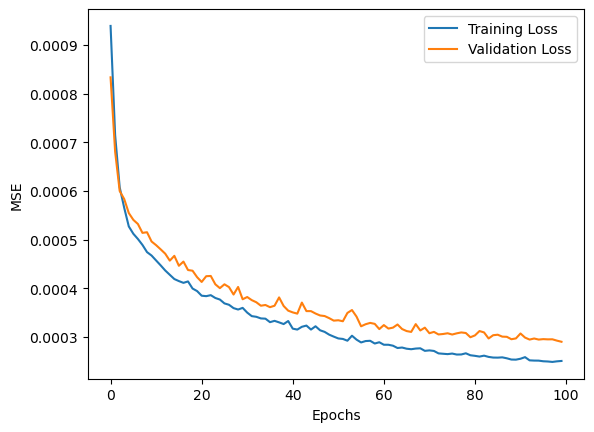

In [11]:
if not isRF:
    if not isTrain:
        with open(SAVE_PATH, 'r') as f:
            loss_file = f.read().splitlines()[1]
            loss_file = loss_file.split(os.path.sep)[-1].split('/')[-1]
            loss_file = os.path.join(paths.LOSSES_ROOT, loss_file)
        history = pd.read_csv(loss_file).to_dict(orient='list')
    plt.figure()
    plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
    plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()

## Evaluate model

### Perform on stylized model

In [12]:
from sklearn.metrics import r2_score, mean_squared_error

if isRF:
    if not isTrain:
        model = joblib.load(PARAM_PATH)
    y = labels_test.copy()
    output = model.predict(summ_stats_test)
else:
    device = torch.device('cpu')
    if not isTrain:
        model.load_state_dict(torch.load(PARAM_PATH, map_location=torch.device('cpu')))
    model.to(device)
    model.eval()

    y = []
    output = []
    for X, Y in test_loader:
        y.append(Y.to("cpu").detach().numpy())
        output.append(model(X.to(device)).to("cpu").detach().numpy())
    y = np.concatenate(y, axis=0)
    output = np.concatenate(output, axis=0)

# RMSE of normalized outputs
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.2225
R2 Score:
y-shift,   0.772
d,         0.972
theta,     0.758
l_t,       0.896
lr_pt,     0.449
r_t,       0.942
rr_dt,     0.429


Stylized Cell Testing Data: Ground Truth VS Predicted


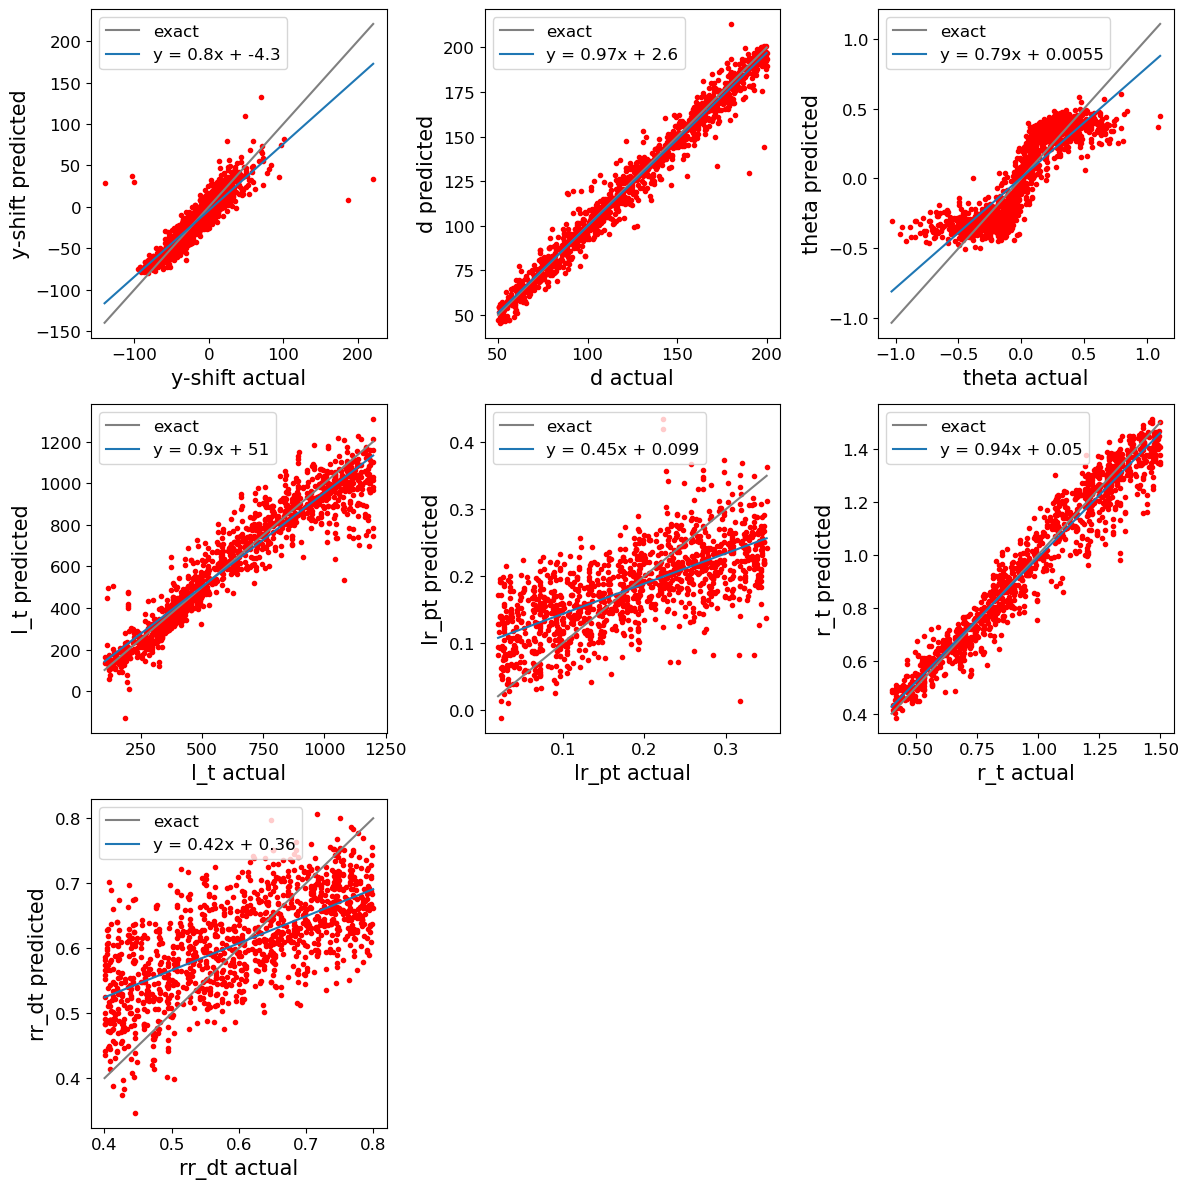

In [13]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

fig = plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

if isTrain:
    fig.savefig(os.path.join(MODEL_PATH, 'test_result.pdf'))

#### Check prediction on orientation

In [14]:
if check_orient:
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

    bins = 30
    angle = np.arccos(cosine_similarity(y[:, orient_idx2], output[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 8))
    angle *= 180 / np.pi
    h_err = 180 / np.pi * (np.arccos(output[:, orient_idx2[0]]) - np.arccos(y[:, orient_idx2[0]]))
    phi_err = 180 / np.pi * (output[:, orient_idx2[1]] - y[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx2[0]])

    # angle error vs. h angle
    fig1 = plt.figure(figsize=(10, 8))
    # h error
    plt.subplot(311)
    plt.axhline(0, color='k')
    plt.plot(h_angle, h_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.ylabel('h error (deg)')
    # phi error
    plt.subplot(312)
    plt.axhline(0, color='k')
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(313)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 90])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error vs. trunk length
    try:
        l_t_idx = display_list.index('l_t')
    except:
        l_t_idx = None
    if l_t_idx is not None:
        l_t = y[:, l_t_idx]
        fig2 = plt.figure(figsize=(10, 8))
        # h error
        plt.subplot(311)
        plt.axhline(0, color='k')
        plt.plot(l_t, h_err, 'r.')
        plt.ylim([-90, 90])
        plt.ylabel('h error (deg)')
        # phi error
        plt.subplot(312)
        plt.axhline(0, color='k')
        plt.plot(l_t, phi_err, 'r.')
        plt.ylim([-90, 90])
        plt.ylabel('phi error (deg)')
        # angle error
        plt.subplot(313)
        plt.plot(l_t, angle, 'r.')
        plt.ylim([0, 90])
        plt.xlabel('true trunk length')
        plt.ylabel('angle error (deg)')

        if isTrain:
            fig2.savefig(os.path.join(MODEL_PATH, 'angle_error_vs_trunk_length.png'))

    # angle error distribution
    fig3 = plt.figure(figsize=(10, 6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 90))
    plt.xlim([0, 90])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 90), density=True, weights=weights)
    plt.xlim([0, 90])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

    if isTrain:
        fig1.savefig(os.path.join(MODEL_PATH, 'angle_error_vs_h.png'))
        fig3.savefig(os.path.join(MODEL_PATH, 'angle_error_distribution.png'))